In [1]:
# This is not needed on machines that have pip installed topologicpy
import sys
sys.path.append("C:/Users/sarwj/OneDrive - Cardiff University/Documents/GitHub/topologicpy/src/")


In [2]:
# Import all the classes that you will use here.
from topologicpy.Vertex import Vertex
from topologicpy.Edge import Edge
from topologicpy.Wire import Wire
from topologicpy.Face import Face
from topologicpy.Shell import Shell
from topologicpy.Cluster import Cluster
from topologicpy.Topology import Topology
from topologicpy.Dictionary import Dictionary

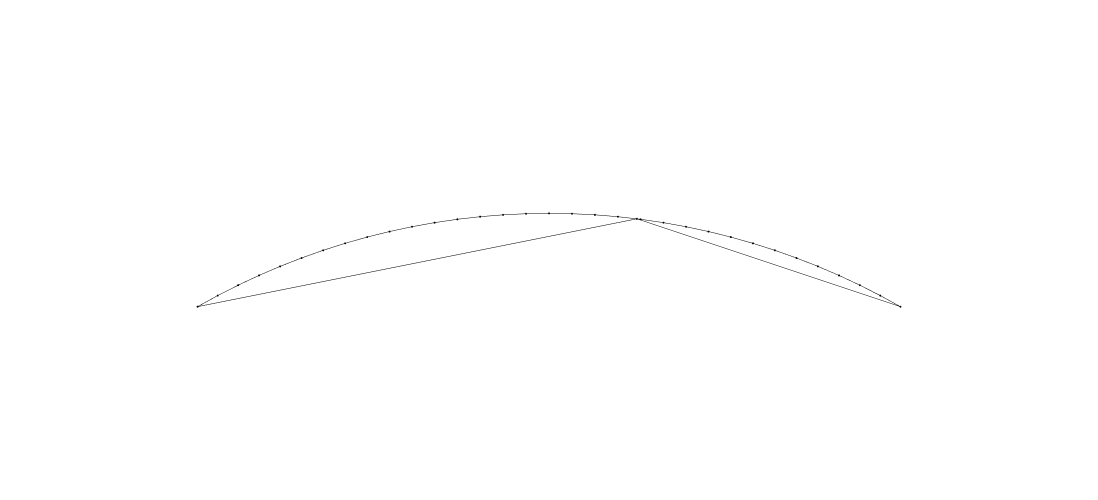

In [3]:
# Example of creating a segmented arc that passes through three vertices.
# Create three vertices
sv = Vertex.ByCoordinates(2, 0, 0)
mv = Vertex.ByCoordinates(0.5, 0.5, 0)
ev = Vertex.ByCoordinates(-2, 0, 0)

# Create two edges between the vertices
e1 = Edge.ByVertices(sv, mv)
e2 = Edge.ByVertices(mv, ev)

# Create an arc that passes through the three vertices
arc = Wire.Arc(startVertex=sv, middleVertex=mv, endVertex=ev, sides=32, close= False)

# Show that arc
Topology.Show(arc, e1, e2, renderer="jupyterlab", projection="ortho", camera=[0,0,3], up=[0,1,0])

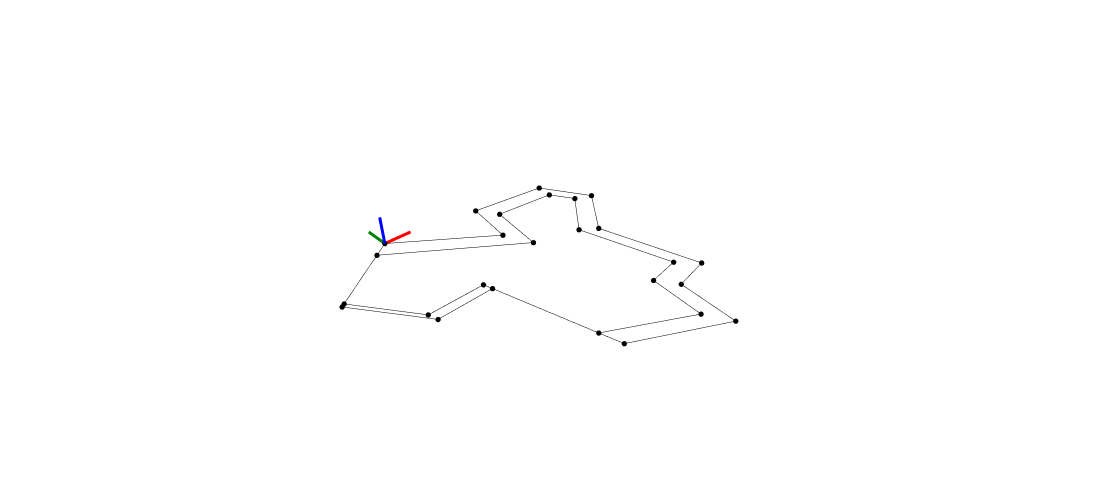

In [6]:
# Example of creating an offset wire. This works for both closed and open wires, but they must be manifold (connected head to tail like a polyline)

# Create an Einstein mono-tile wire
r = Wire.Einstein(radius=30)
# Rotate it just to show that wires do not have to be in the XY plane for them to work. They can be in 3D space.
r = Topology.Rotate(r, axis=[0,1,1,], angle=20)
# Get its edges
edges = Topology.Edges(r)
# Loop through the edges and asssign them random offsets
for i, edge in enumerate(edges):
    d = Dictionary.ByKeyValue("offset", min((i),5))
    if i == 3:
        d = Dictionary.ByKeyValue("offset", 0.0)
    edge = Topology.SetDictionary(edge, d)

# Create a new offset wire based on the custom edge offsets
new_wire = Wire.ByOffset(r, offset=3, offsetKey="offset", bisectors=False, tolerance=0.0001)
Topology.Show(new_wire, r, vertexSize=3, renderer="jupyterlab", xAxis=True, yAxis=True, zAxis=True, axisSize=6)

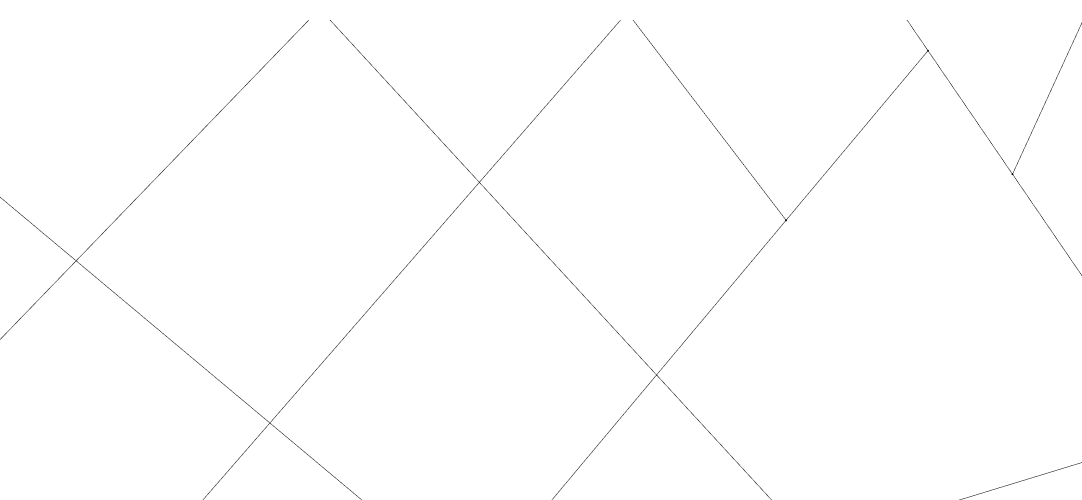

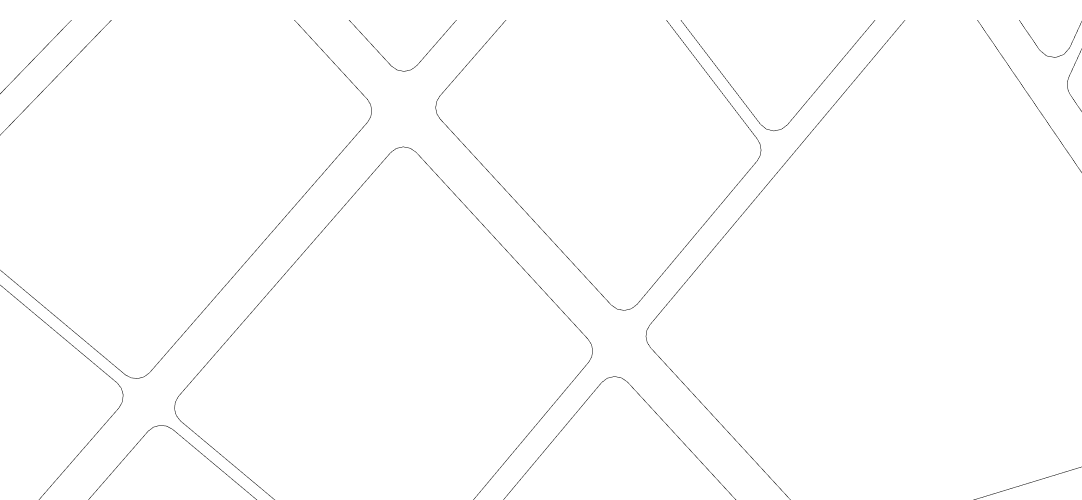

In [13]:
# Example of creating a road/parcel plan with custom offsets and fillets
# Path to the DXF file. Change to match your file path
dxf_path = "C:/Users/sarwj/Downloads/Archive/Boundary.dxf"

# Load the DXF file. This is assumed to have both the boundary (closed polyline) and the roads (lines/edges)
everything = Topology.ByDXFPath(dxf_path)

# Show the imported DXF file
Topology.Show(everything, projection="ortho", camera=[0,0,3], up=[0,1,0], renderer="jupyterlab")

# Separate the boundary from the roads. Save boundary in "boundary" and the roads in "edges"
edges = []
for t in everything:
    if Topology.IsInstance(t, "Wire"):
        boundary = t
    else:
        edges.append(t)

# Tell topologicpy the key name under which you stored the width of the road
width_key = "width"

# Tell topologicpy the key name under which you want to store the offset value. The default is "offset"
offset_key = "offset"

# Assign a "width" to each road by their position in the list. This information can come from Revit/GIS etc.
for i, edge in enumerate(edges):
    d = Dictionary.ByKeyValue(width_key, max(min(i, 14), 4)) # Cap the minimum width to 4 meters and the maximum width to 14 meters.
    edge = Topology.SetDictionary(edge, d)

# Slicing the boundary by the roads to create the parcel wires
# Make a face out of the boundary wire
face = Face.ByWire(boundary)
# Slice the face. This makes a shell
shell = Topology.Slice(face, Cluster.ByTopologies(edges))
# Get the individual faces of the shell.
faces = Topology.Faces(shell)
# Convert the resulting faces back to wires
wires = [Face.ExternalBoundary(f) for f in faces]
# Remove Collinear Edges of each wire to avoid problems with offsetting
wires = [Wire.RemoveCollinearEdges(w) for w in wires]

# Transfer Dictionaries from the original road edges to the edges of each wire by testing the centroid of each wire edge to see what road it belongs to.
# Assign a default offset/setback of 0 if an edge does not belong to a road (i.e. belongs to a boundary)
for wire in wires:
    wire_edges = Topology.Edges(wire)
    for wire_edge in wire_edges:
        wire_edge = Topology.SetDictionary(wire_edge, Dictionary.ByKeyValue(offset_key,0), silent=True)
        c = Topology.Centroid(wire_edge)
        for edge in edges:
            if Vertex.Distance(c, edge) < 0.01:
                road_dictionary = Topology.Dictionary(edge)
                road_width = Dictionary.ValueAtKey(road_dictionary, width_key)
                offset = road_width * 0.5 #Set the offset to half the road width.
                edge_dictionary = Dictionary.ByKeyValue(offset_key, offset)
                wire_edge = Topology.SetDictionary(wire_edge, edge_dictionary, silent=True)
                break

# Offset and fillet the wires in one go.
offset_wires = [Wire.Fillet(Wire.ByOffset(w, offsetKey=offset_key), radius=6, sides=4) for w in wires]
Topology.Show(offset_wires, boundary, vertexSize=0.001, renderer="jupyterlab", projection="ortho", camera=[0,0,3], up=[0,1,0])